In [1]:
import tensorflow as tf
import numpy as np

import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)}) # set figure size for plotting in seaborn

In [3]:
def data_generator():
    while True:
        
        # draw 6 numbers from standard normal distribution
        
        datum = np.random.randn(6)       
        
        # define an offset
        offset = 0.3
        
        noise = np.random.randn() * 0.05
        
        target = np.sum(datum ** 2 ) + offset + noise
        
        # get the input, output pair as tf tensors
        yield (tf.constant(datum, dtype=tf.float32), tf.constant(target, dtype=tf.float32))

In [4]:
# sample an (input, output) pair from the generator
next(data_generator())

2021-10-30 16:11:55.404172: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-30 16:11:55.405083: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-30 16:11:55.411151: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-30 16:11:55.411719: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-30 16:11:55.412366: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

(<tf.Tensor: shape=(6,), dtype=float32, numpy=
 array([-0.56280106,  0.77276677, -1.6711123 ,  0.01961729, -0.25016376,
         1.336652  ], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=float32, numpy=5.8675985>)

 SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-30 16:11:55.529863: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-30 16:11:55.530269: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-30 16:11:55.530775: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-30 16:11:56.058640: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-30 16:11:5

In [31]:
# define a model in tensorflow

class tf_model(tf.keras.Model):
    def __init__(self):
        super(tf_model, self).__init__()
        
        # define model variable (offset)
        
        initializer = tf.keras.initializers.RandomNormal(mean=1)
        variable_shape = [1]
        
        self.model_variable = tf.Variable(initializer(variable_shape),
                                          dtype=tf.float32)
          
        # define model loss metric to keep track of the loss
        
        self.loss_metric = tf.keras.metrics.Mean()
        
    @tf.function
    def __call__(self, x):
        
        # function to fit
        output = tf.reduce_sum(x ** 2  , axis = 1) + self.model_variable
        
        return output


In [32]:
# set training hyperparameters

batch_size = 128
lr = 0.0005
n_epochs = 100
examples_per_epoch = 50

# instantiate model from the above defined model class
model = tf_model()
print(f"The initial parameter value is: {model.trainable_variables[0].numpy()[0]} \n")

# instantiate optimizer (stochastic gradient descent)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

# initialize list of mean loss per epoch for later plotting
epoch_losses = []

The initial parameter value is: 0.9986789226531982 



In [34]:
# create a tensorflow Dataset object from the generator

dataset = tf.data.Dataset.from_generator(
     data_generator,
     output_signature=(
         tf.TensorSpec(shape=(6,), dtype=tf.float32),
         tf.TensorSpec(shape=(), dtype=tf.float32)))


# get batches of this dataset object

dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [35]:
for epoch in range(n_epochs):

    # iterate over 100 randomly generated training examples
    for x_batch, target_batch in dataset.take(examples_per_epoch):

        # calculate model output and loss within the gradient tape
        with tf.GradientTape() as tape:
            prediction_batch = model(x_batch)
            
            loss = tf.keras.losses.MSE(target_batch, prediction_batch)

        # obtain gradients tracked by the gradient tape with respect to the model parameters
        gradients = tape.gradient(loss, model.trainable_variables)

        # apply the gradients to the model parameters using the optimizer
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # update loss metric for later inspection

        model.loss_metric.update_state(loss)
    if not (epoch % 10):
        print(f"The loss after epoch {epoch} is {model.loss_metric.result().numpy()} \n")
    
    epoch_losses.append(model.loss_metric.result().numpy())
    
    model.loss_metric.reset_states()
    
print(f"The final parameter estimate is: {model.trainable_variables[0].numpy()[0]}")

The loss after epoch 0 is 0.4672258496284485 

The loss after epoch 10 is 0.17349128425121307 

The loss after epoch 20 is 0.06568653881549835 

The loss after epoch 30 is 0.025664323940873146 

The loss after epoch 40 is 0.010952133685350418 

The loss after epoch 50 is 0.005750373005867004 

The loss after epoch 60 is 0.0037070270627737045 

The loss after epoch 70 is 0.00291154021397233 

The loss after epoch 80 is 0.0026410995051264763 

The loss after epoch 90 is 0.0025931044947355986 

The final parameter estimate is: 0.30463331937789917


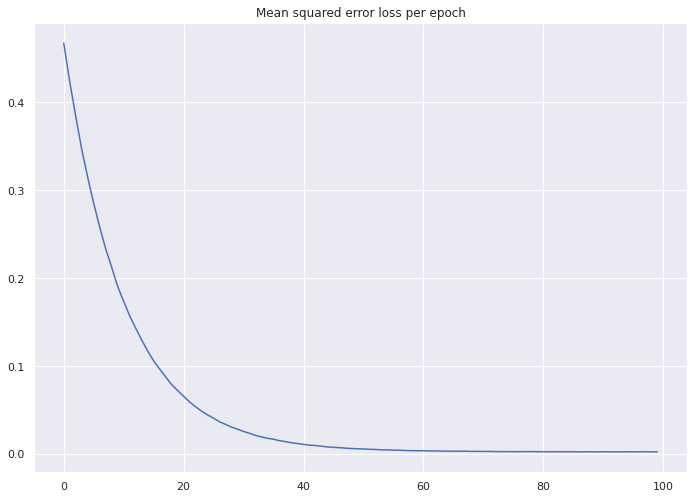

In [36]:
# plot the losses during each epoch
loss_plot = sns.lineplot(x=np.arange(n_epochs), 
                         y=epoch_losses).set_title("Mean squared error loss per epoch")

In [37]:
# Saving the trained model

model.save("model_filename")

ValueError: Model <__main__.tf_model object at 0x7fd9b47bb3a0> cannot be saved because the input shapes have not been set. Usually, input shapes are automatically determined from calling `.fit()` or `.predict()`. To manually set the shapes, call `model.build(input_shape)`.